In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
import tensorflow as tf

from keras.layers import Input, Dropout, Dense
from keras.models import Model, Sequential, load_model
from keras import regularizers
from keras.models import model_from_json

# EDA

In [2]:
file_path = "/content/drive/MyDrive/GTG Data/GTG_B_Data.xlsx"
sheet_name = 'No Confidence'
df = pd.read_excel(file_path, sheet_name=sheet_name)
df

,Timestamp,KVAR,V,I,R,GND_EX,GND_EY,GNE_EX,GNE_EY,GNE_E,GND_E,WIND_A,WIND_B,WIND_C
0,2017-02-15 00:00:00,632.8125,23.647461,1.358093,2.804810,0.524521,0.511170,0.396729,0.406266,159.600006,156.400009,128.699997,132.800003,135.199997
1,2017-02-15 00:01:00,634.8125,21.700195,1.351624,3.092529,0.564576,0.513077,0.387192,0.392914,159.500000,156.400009,129.000000,132.699997,135.000000
2,2017-02-15 00:02:00,623.6250,27.373047,1.341919,2.694946,0.564576,0.522614,0.383377,0.391007,159.500000,156.400009,128.900009,132.900009,135.199997
3,2017-02-15 00:03:00,623.6250,27.373047,1.341919,2.694946,0.564576,0.522614,0.383377,0.391007,159.500000,156.400009,128.900009,132.900009,135.199997
4,2017-02-15 00:04:00,630.1875,24.840820,1.341919,2.819336,0.600815,0.530243,0.408173,0.400544,159.400009,156.400009,128.900009,132.800003,135.300003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
532796,2018-02-19 23:56:00,890.2500,23.442383,1.372498,2.710083,0.774384,0.743867,0.970841,0.753403,153.000000,150.300003,132.900009,136.900009,139.199997
532797,2018-02-19 23:57:00,902.2500,31.007812,1.375610,2.599487,0.776291,0.720978,0.961304,0.753403,153.000000,150.300003,132.500000,137.100006,139.600006
532798,2018-02-19 23:58:00,891.8125,22.878906,1.363159,2.637573,0.793458,0.738144,0.991822,0.762940,152.900009,150.199997,132.800003,137.000000,139.199997
532799,2018-02-19 23:59:00,881.0000,22.792969,1.360046,2.679077,0.776291,0.741959,0.974656,0.762940,152.900009,150.199997,132.800003,137.000000,139.100006


In [3]:
# Basic Statistics
print(df.describe())

                KVAR              V              I              R  \
count  532801.000000  532801.000000  532801.000000  532801.000000   
mean      677.856439      22.221730       1.300191       2.598007   
std       327.829668       7.380388       0.390940       0.799802   
min         0.000000       0.000000       0.000000       0.000000   
25%       545.093750      20.666016       1.319214       2.666992   
50%       652.937500      23.172852       1.358093       2.861938   
75%       700.812500      25.728516       1.393738       2.994629   
max      1839.000000      62.570312       2.181396       4.817871   

              GND_EX         GND_EY         GNE_EX         GNE_EY  \
count  532801.000000  532801.000000  532801.000000  532801.000000   
mean        0.490906       0.454043       0.400004       0.335478   
std         0.105473       0.097633       0.110995       0.097851   
min         0.038147       0.020981       0.040054       0.038147   
25%         0.434876       0.4177

In [4]:
print(df.isnull().sum())

Timestamp    0
KVAR         0
V            0
I            0
R            0
GND_EX       0
GND_EY       0
GNE_EX       0
GNE_EY       0
GNE_E        0
GND_E        0
WIND_A       0
WIND_B       0
WIND_C       0
dtype: int64


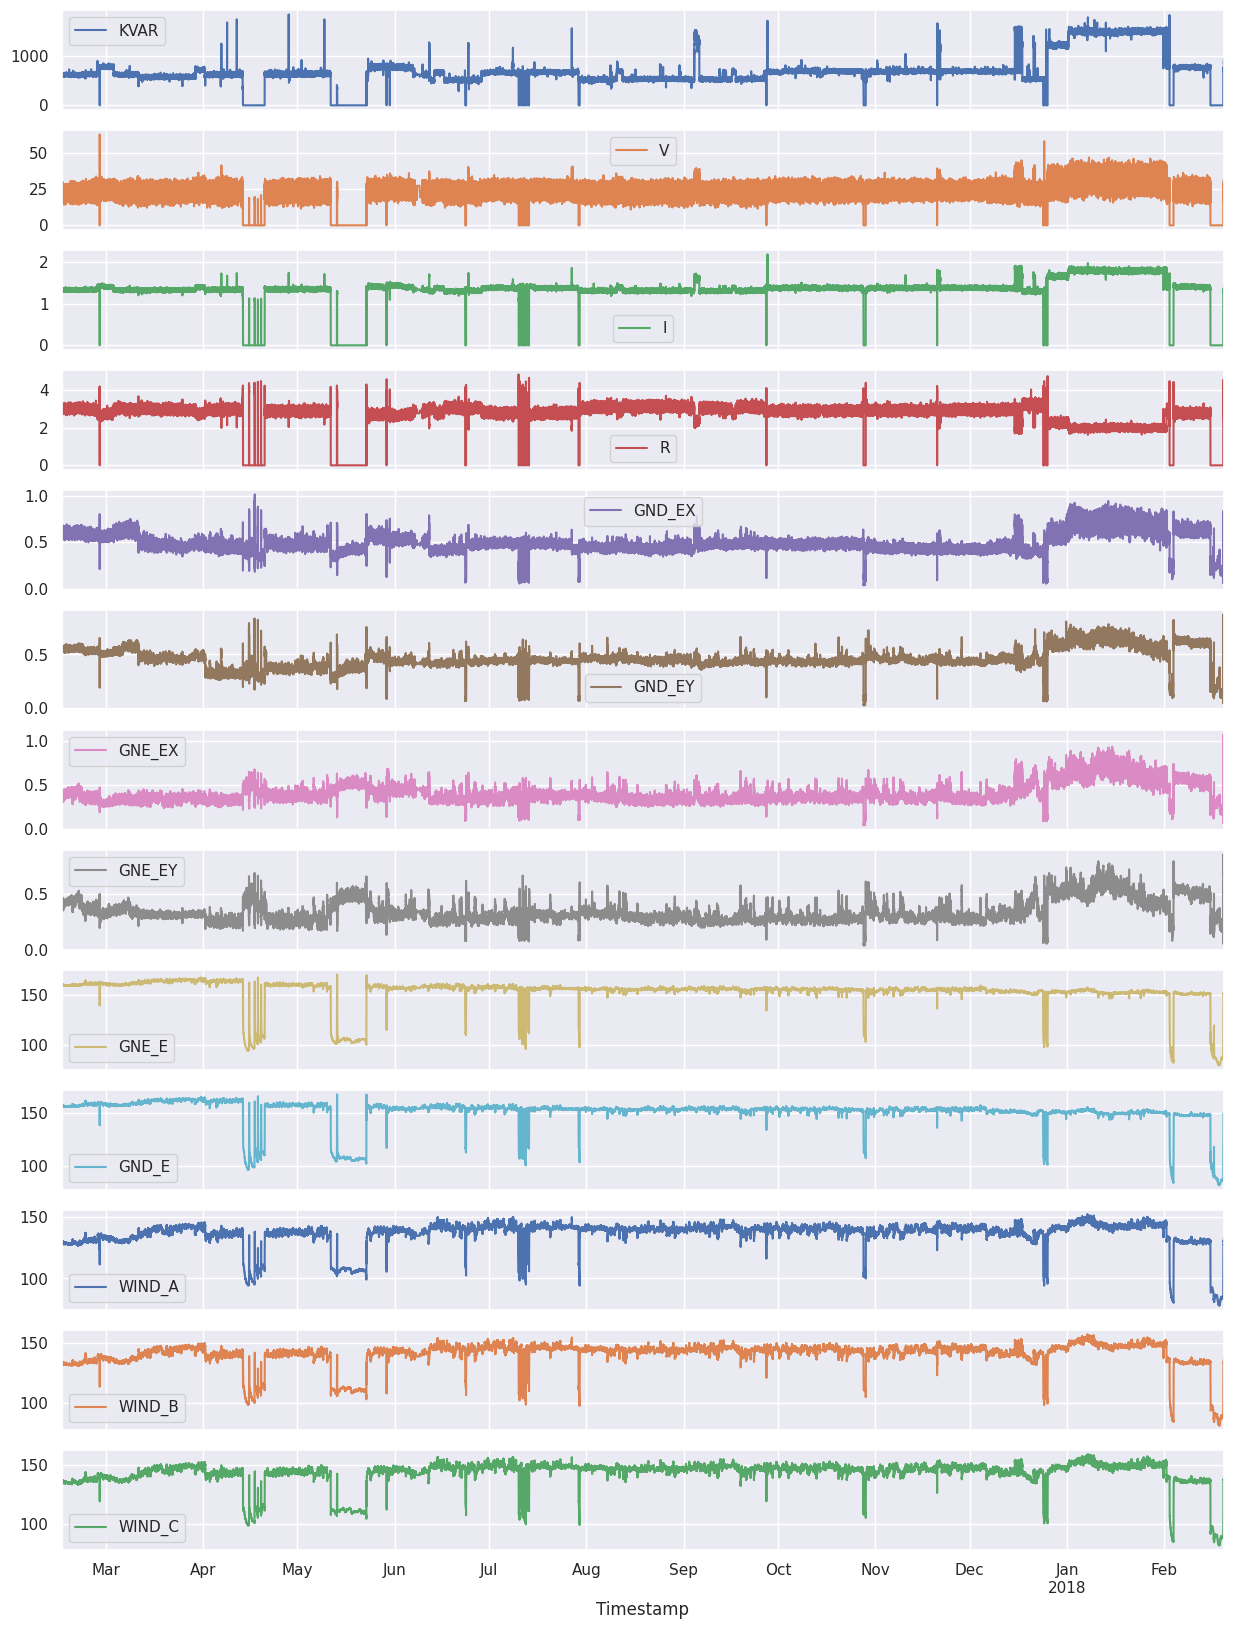

In [5]:
# Plot historical data
plot_df = df.copy()
plot_df['Timestamp'] = pd.to_datetime(plot_df['Timestamp'])
plot_df.set_index('Timestamp', inplace=True)
plot_df.plot(subplots=True, figsize=(15, 20))
plt.show()

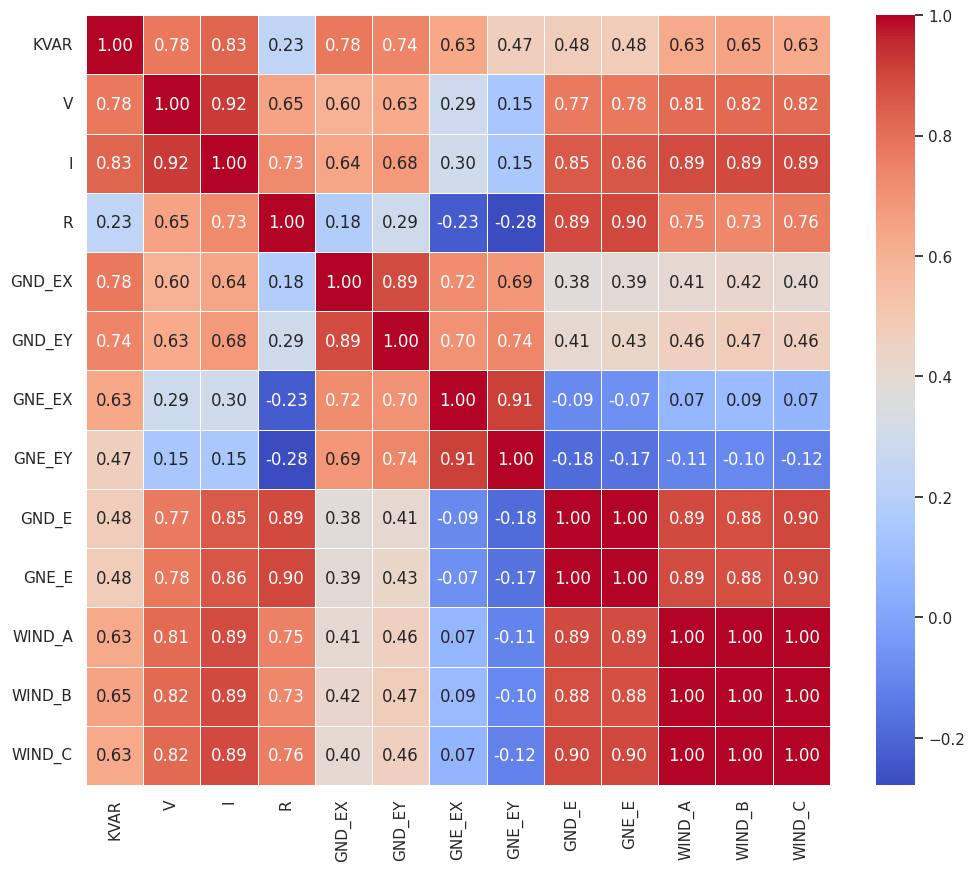

In [6]:
# Correlation Analysis
features = ['KVAR','V','I','R','GND_EX','GND_EY','GNE_EX','GNE_EY','GND_E','GNE_E','WIND_A','WIND_B','WIND_C']
corr_matrix = df[features].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.show()

In [7]:
time = df['Timestamp']
kvar = df['KVAR']
voltage = df['V']
current = df['I']
ripple = df['R']

de_x_vibr = df['GND_EX']
de_y_vibr = df['GND_EY']
ee_x_vibr = df['GNE_EX']
ee_y_vibr = df['GNE_EY']

de_temp = df['GND_E']
ee_temp = df['GNE_E']
a_temp = df['WIND_A']
b_temp = df['WIND_B']
c_temp = df['WIND_C']

In [8]:
idx = 320000

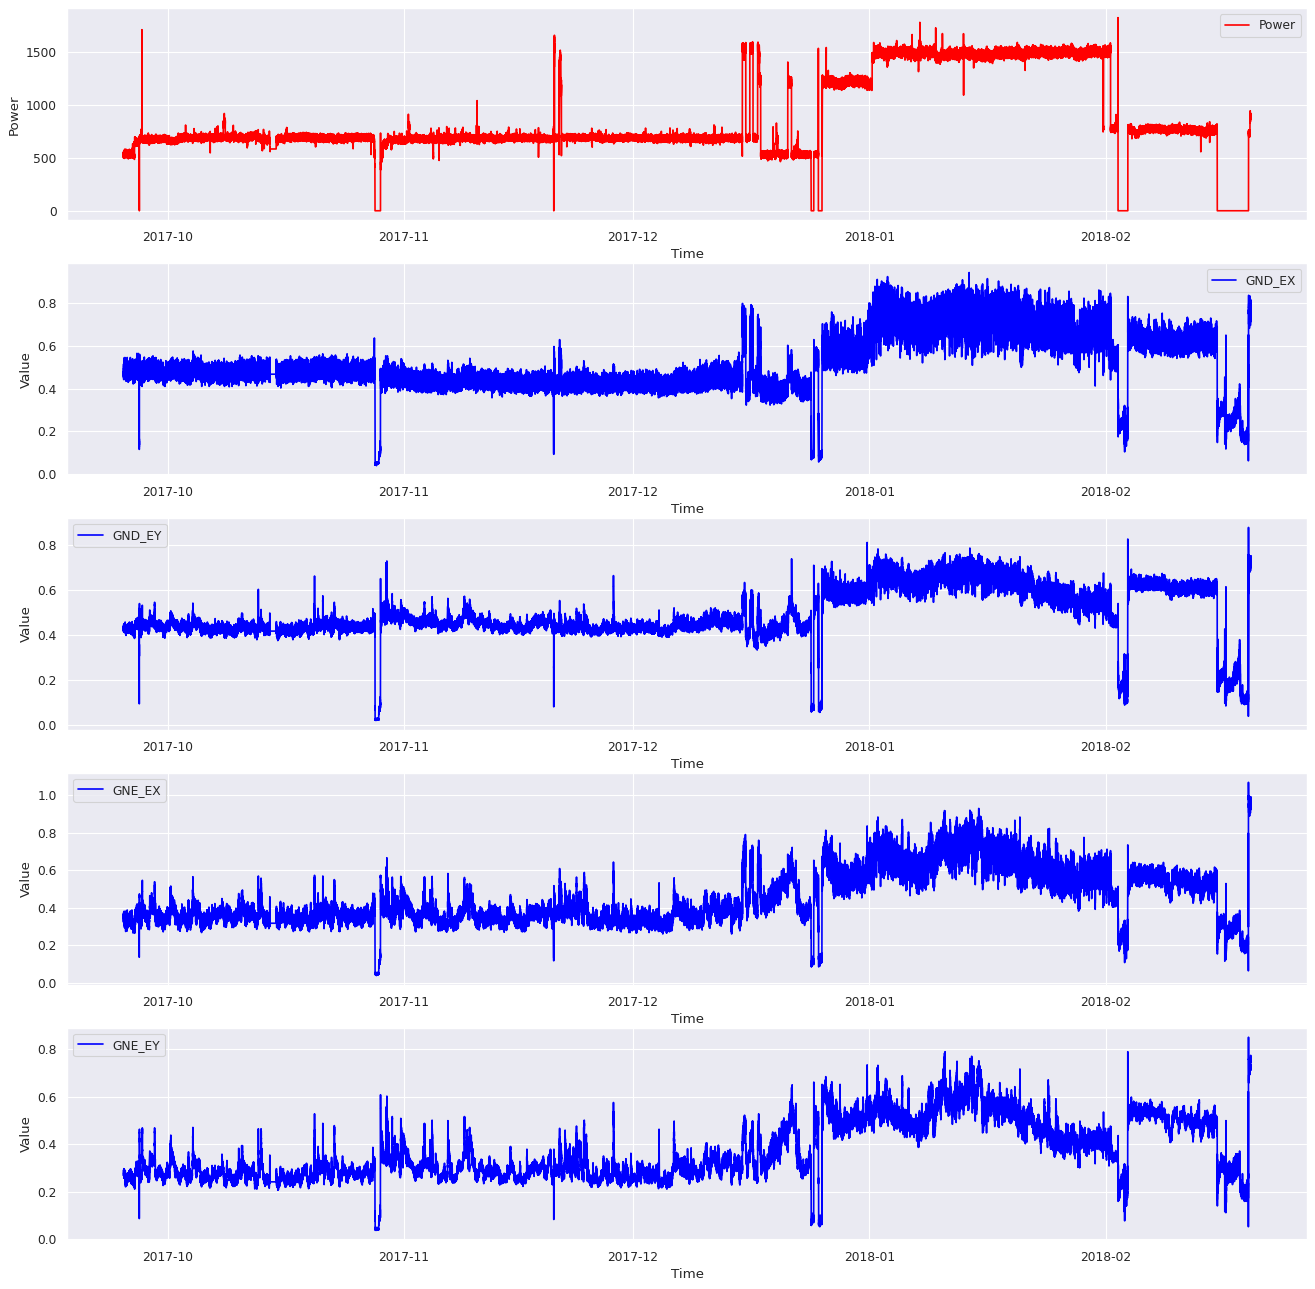

In [9]:
from matplotlib.pyplot import figure
figure(figsize=(20, 20), dpi=80)
plt.subplot(5,1,1)
plt.plot(time[idx:], kvar[idx:], label='Power', color='red')
plt.xlabel('Time')
plt.ylabel('Power')
plt.legend()

plt.subplot(5,1,2)
plt.plot(time[idx:], de_x_vibr[idx:], label='GND_EX', color='blue')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

plt.subplot(5,1,3)
plt.plot(time[idx:], de_y_vibr[idx:], label='GND_EY', color='blue')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

plt.subplot(5,1,4)
plt.plot(time[idx:], ee_x_vibr[idx:], label='GNE_EX', color='blue')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

plt.subplot(5,1,5)
plt.plot(time[idx:], ee_y_vibr[idx:], label='GNE_EY', color='blue')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# Anomaly Detection with PCA (Mahalanobis Distance)

In [ ]:
selected_columns = df[['Timestamp', 'GND_EX', 'GND_EY', 'GNE_EX', 'GNE_EY']]
vibration_data = pd.DataFrame(selected_columns)
#vibration_data = pd.to_datetime(vibration_data['Timestamp'], format='%Y%m.%d.%H.%M.%S')
vibration_data.set_index('Timestamp', inplace=True)
vibration_data

,GND_EX,GND_EY,GNE_EX,GNE_EY
Timestamp,,,,
2017-02-15 00:00:00,0.524521,0.511170,0.396729,0.406266
2017-02-15 00:01:00,0.564576,0.513077,0.387192,0.392914
2017-02-15 00:02:00,0.564576,0.522614,0.383377,0.391007
2017-02-15 00:03:00,0.564576,0.522614,0.383377,0.391007
2017-02-15 00:04:00,0.600815,0.530243,0.408173,0.400544
...,...,...,...,...
2018-02-19 23:56:00,0.774384,0.743867,0.970841,0.753403
2018-02-19 23:57:00,0.776291,0.720978,0.961304,0.753403
2018-02-19 23:58:00,0.793458,0.738144,0.991822,0.762940


<Axes: xlabel='Timestamp'>

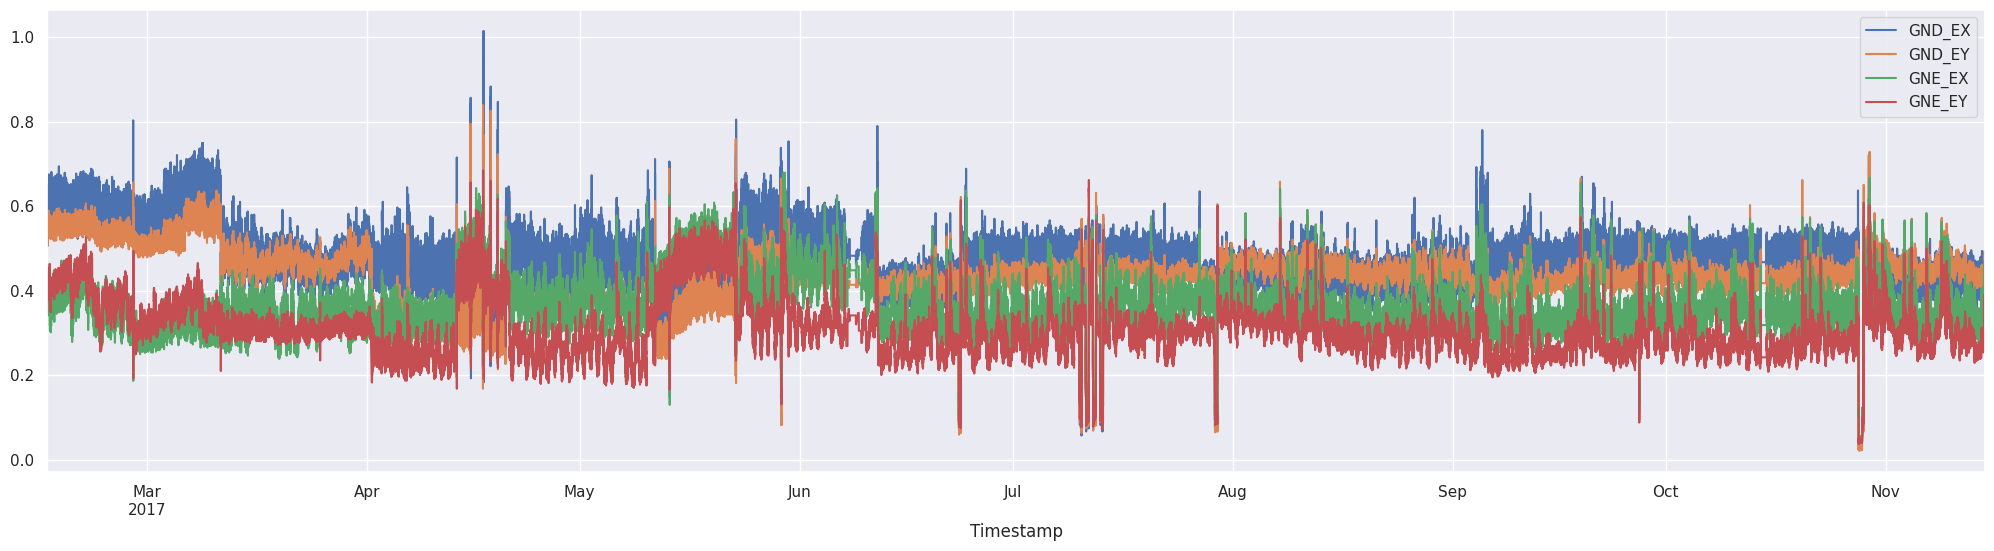

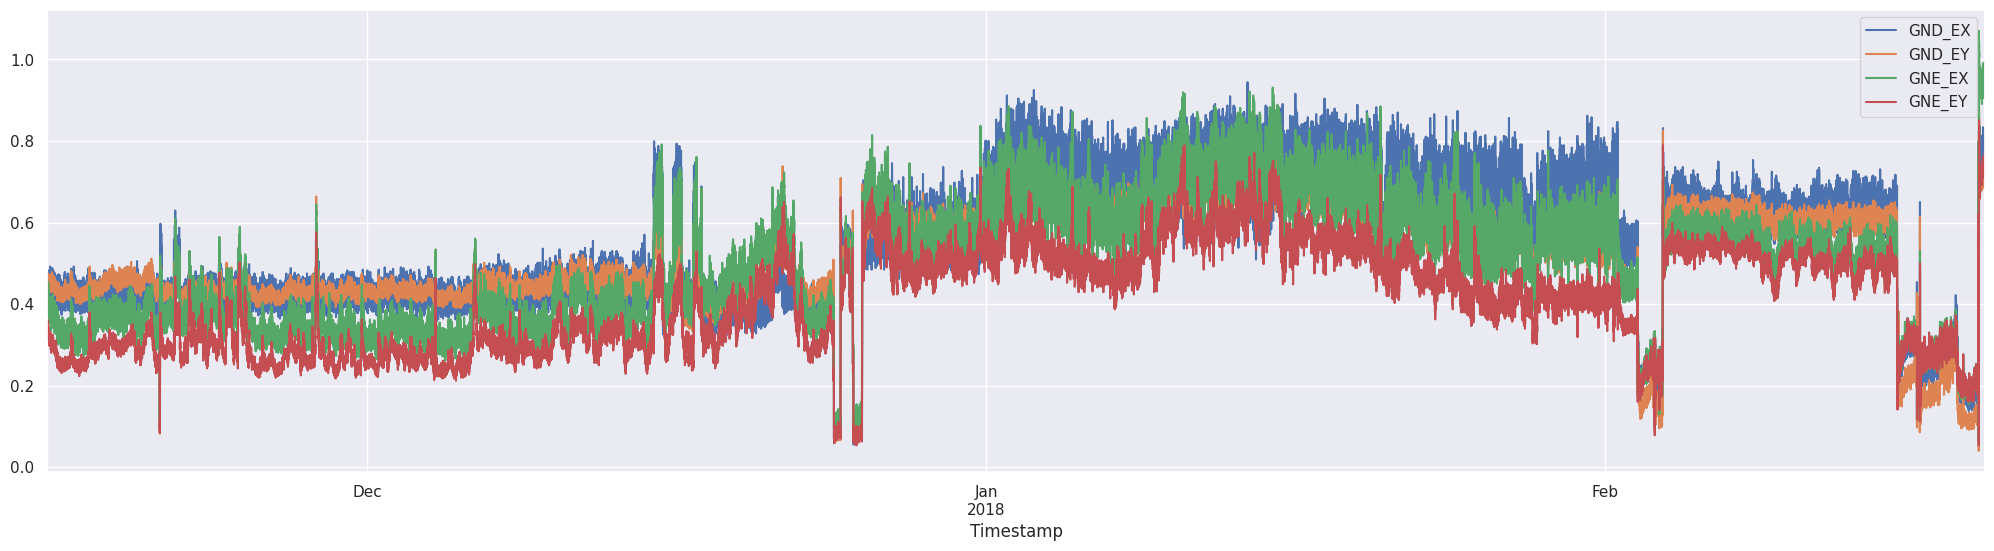

In [ ]:
idx_vibr = 0
dataset_train = vibration_data['2017-02-15 00:00:00':'2017-11-15 00:00:00']
dataset_test = vibration_data['2017-11-15 00:00:00':]
dataset_train.plot(figsize = (25,6))
dataset_test[idx_vibr:].plot(figsize = (25,6))

In [ ]:
scaler = preprocessing.MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(dataset_train),
                              columns=dataset_train.columns,
                              index=dataset_train.index)
# Random shuffle training data
X_train.sample(frac=1)

X_test = pd.DataFrame(scaler.transform(dataset_test),
                             columns=dataset_test.columns,
                             index=dataset_test.index)


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, svd_solver= 'full')
X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(X_train_PCA)
X_train_PCA.index = X_train.index

X_test_PCA = pca.transform(X_test)
X_test_PCA = pd.DataFrame(X_test_PCA)
X_test_PCA.index = X_test.index


In [ ]:
def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

In [ ]:
def cov_matrix(data, verbose=False):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            return covariance_matrix, inv_covariance_matrix
        else:
            print("Error: Inverse Covariance Matrix NOT positive definite")
    else:
        print("Error: Covariance Matrix NOT positive definite")


In [ ]:
def MahalanobisDist(inv_cov_matrix, mean_distr, data, verbose=False):
    inv_covariance_matrix = inv_cov_matrix
    vars_mean = mean_distr
    diff = data - vars_mean
    md = []
    for i in range(len(diff)):
        md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))
    return md


In [ ]:
def MD_detectOutliers(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    outliers = []
    for i in range(len(dist)):
        if dist[i] >= threshold:
            outliers.append(i)  # index of the outlier
    return np.array(outliers)


In [ ]:
def MD_threshold(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    return threshold


In [ ]:
data_train = np.array(X_train_PCA.values)
data_test = np.array(X_test_PCA.values)


In [ ]:
cova_matrix, inv_cova_matrix  = cov_matrix(data_train)
mean_distr = data_train.mean(axis=0)


In [ ]:
dist_test = MahalanobisDist(inv_cova_matrix, mean_distr, data_test, verbose=False)
dist_train = MahalanobisDist(inv_cova_matrix, mean_distr, data_train, verbose=False)
threshold = MD_threshold(dist_train, extreme = True)

<ipython-input-53-16f501195e56>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.square(dist_train),


(0.0, 15.0)

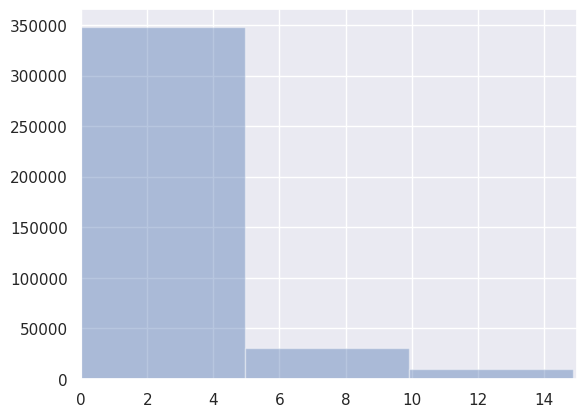

In [ ]:
plt.figure()
sns.distplot(np.square(dist_train),
             bins = 10,
             kde= False);
plt.xlim([0.0,15])

<ipython-input-54-83d138eb2ebc>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dist_train,


Text(0.5, 0, 'Mahalanobis dist')

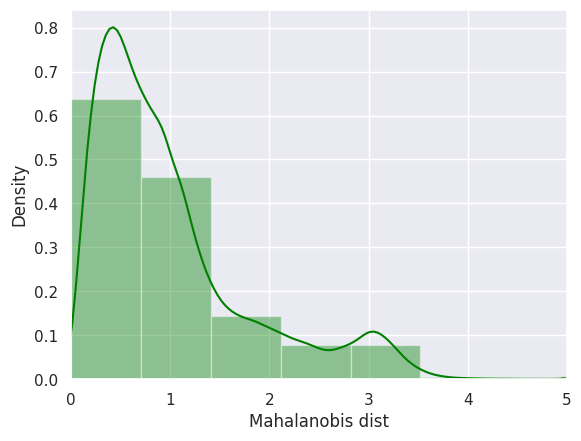

In [ ]:
plt.figure()
sns.distplot(dist_train,
             bins = 10,
             kde= True,
            color = 'green');
plt.xlim([0.0,5])
plt.xlabel('Mahalanobis dist')


In [ ]:
anomaly_train = pd.DataFrame()
anomaly_train['Mob dist']= dist_train
anomaly_train['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly_train['Anomaly'] = anomaly_train['Mob dist'] > anomaly_train['Thresh']
anomaly_train.index = X_train_PCA.index
anomaly = pd.DataFrame()
anomaly['Mob dist']= dist_test
anomaly['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly['Anomaly'] = anomaly['Mob dist'] > anomaly['Thresh']
anomaly.index = X_test_PCA.index
anomaly

,Mob dist,Thresh,Anomaly
Timestamp,,,
2017-11-15 00:00:00,0.568999,3.182984,False
2017-11-15 00:01:00,0.700188,3.182984,False
2017-11-15 00:02:00,0.894324,3.182984,False
2017-11-15 00:03:00,0.716704,3.182984,False
2017-11-15 00:04:00,0.887273,3.182984,False
...,...,...,...
2018-02-19 23:56:00,8.788726,3.182984,True
2018-02-19 23:57:00,8.686186,3.182984,True
2018-02-19 23:58:00,9.032016,3.182984,True


In [ ]:
anomaly_alldata = pd.concat([anomaly_train, anomaly])
#anomaly_alldata.to_csv('Anomaly_distance.csv',sep=';')


In [ ]:
anomaly_alldata

,Mob dist,Thresh,Anomaly
Timestamp,,,
2017-02-15 00:00:00,1.333197,3.182984,False
2017-02-15 00:01:00,1.442886,3.182984,False
2017-02-15 00:02:00,1.507403,3.182984,False
2017-02-15 00:03:00,1.507403,3.182984,False
2017-02-15 00:04:00,1.812819,3.182984,False
...,...,...,...
2018-02-19 23:56:00,8.788726,3.182984,True
2018-02-19 23:57:00,8.686186,3.182984,True
2018-02-19 23:58:00,9.032016,3.182984,True


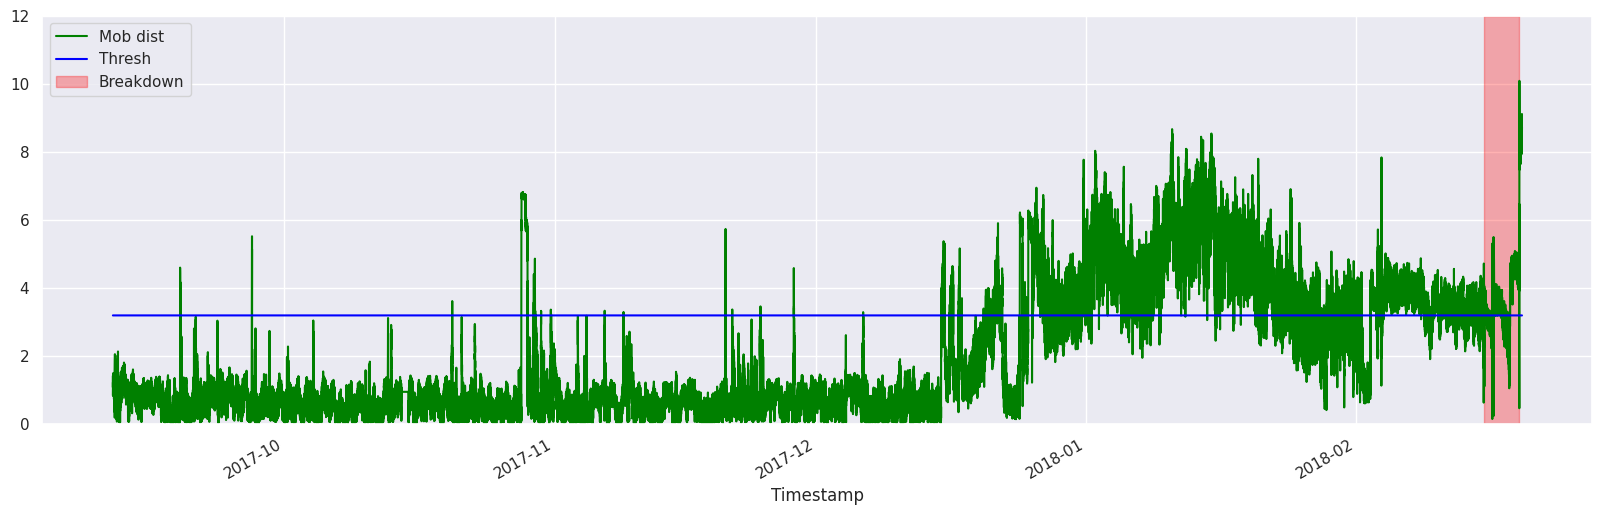

In [ ]:
# Verify on Test Data
idx_pca = 300000
fig_pca = anomaly_alldata[idx_pca:].plot(logy=False, figsize = (20,6), ylim = [0,12], color = ['green','blue'])
fig_pca.axvspan('2018-02-15 14:22', '2018-02-19 16:55', alpha=0.3, color='red', label='Breakdown')
plt.legend()
plt.show()

# Anomaly Detection using Autoencoder

In [ ]:
import keras

In [ ]:
seed(10)
keras.utils.set_random_seed(10)
act_func = 'elu'

# Input layer:
model=Sequential()
# First hidden layer, connected to input vector X.
model.add(Dense(10,activation=act_func,
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(0.0),
                input_shape=(X_train.shape[1],)
               )
         )

model.add(Dense(2,activation=act_func,
                kernel_initializer='glorot_uniform'))

model.add(Dense(10,activation=act_func,
                kernel_initializer='glorot_uniform'))

model.add(Dense(X_train.shape[1],
                kernel_initializer='glorot_uniform'))

model.compile(loss='mse',optimizer='adam')

# Train model for 100 epochs, batch size of 10:
NUM_EPOCHS=20
BATCH_SIZE=200

In [ ]:
history=model.fit(np.array(X_train),np.array(X_train),
                  batch_size=BATCH_SIZE,
                  epochs=NUM_EPOCHS,
                  validation_split=0.05,
                  verbose = 1)

Epoch 1/20
1868/1868 [==============================] - 5s 2ms/step - loss: 0.0029 - val_loss: 8.9252e-04
Epoch 2/20
1868/1868 [==============================] - 5s 3ms/step - loss: 7.9928e-04 - val_loss: 8.1126e-04
Epoch 3/20
1868/1868 [==============================] - 4s 2ms/step - loss: 7.7561e-04 - val_loss: 6.3130e-04
Epoch 4/20
1868/1868 [==============================] - 4s 2ms/step - loss: 7.5263e-04 - val_loss: 8.1732e-04
Epoch 5/20
1868/1868 [==============================] - 4s 2ms/step - loss: 7.2624e-04 - val_loss: 9.2864e-04
Epoch 6/20
1868/1868 [==============================] - 5s 3ms/step - loss: 7.0801e-04 - val_loss: 7.8348e-04
Epoch 7/20
1868/1868 [==============================] - 4s 2ms/step - loss: 6.7536e-04 - val_loss: 9.0242e-04
Epoch 8/20
1868/1868 [==============================] - 4s 2ms/step - loss: 6.5365e-04 - val_loss: 7.7967e-04
Epoch 9/20
1868/1868 [==============================] - 3s 2ms/step - loss: 6.3648e-04 - val_loss: 7.5111e-04
Epoch 10/20
18

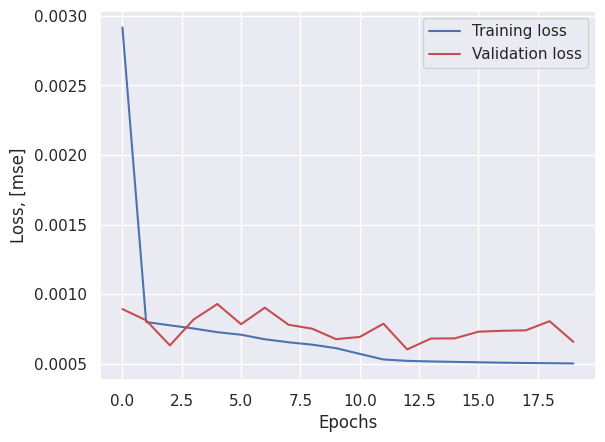

In [ ]:
plt.plot(history.history['loss'],
         'b',
         label='Training loss')
plt.plot(history.history['val_loss'],
         'r',
         label='Validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss, [mse]')
plt.show()

12286/12286 [==============================] - 18s 1ms/step


<ipython-input-63-0fb41d3703f4>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scored['Loss_mae'],


(0.0, 0.5)

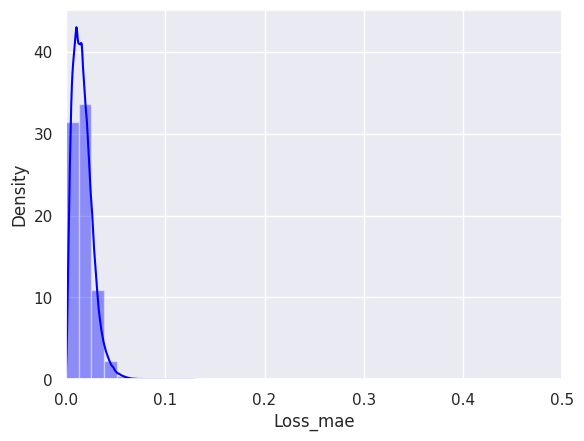

In [ ]:
X_pred = model.predict(np.array(X_train))
X_pred = pd.DataFrame(X_pred,
                      columns=X_train.columns)
X_pred.index = X_train.index

scored = pd.DataFrame(index=X_train.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_train), axis = 1)
plt.figure()
sns.distplot(scored['Loss_mae'],
             bins = 10,
             kde= True,
            color = 'blue');
plt.xlim([0.0,.5])

In [ ]:
X_pred = model.predict(np.array(X_test))
X_pred = pd.DataFrame(X_pred,
                      columns=X_test.columns)
X_pred.index = X_test.index

scored = pd.DataFrame(index=X_test.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_test), axis = 1)
scored['Threshold'] = 0.06
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

4366/4366 [==============================] - 7s 2ms/step


,Loss_mae,Threshold,Anomaly
Timestamp,,,
2017-11-15 00:00:00,0.022582,0.06,False
2017-11-15 00:01:00,0.022614,0.06,False
2017-11-15 00:02:00,0.019356,0.06,False
2017-11-15 00:03:00,0.024143,0.06,False
2017-11-15 00:04:00,0.024283,0.06,False


In [ ]:
scored

,Loss_mae,Threshold,Anomaly
Timestamp,,,
2017-11-15 00:00:00,0.022582,0.06,False
2017-11-15 00:01:00,0.022614,0.06,False
2017-11-15 00:02:00,0.019356,0.06,False
2017-11-15 00:03:00,0.024143,0.06,False
2017-11-15 00:04:00,0.024283,0.06,False
...,...,...,...
2018-02-19 23:56:00,0.118794,0.06,True
2018-02-19 23:57:00,0.103432,0.06,True
2018-02-19 23:58:00,0.116794,0.06,True


In [ ]:
X_pred_train = model.predict(np.array(X_train))
X_pred_train = pd.DataFrame(X_pred_train,
                      columns=X_train.columns)
X_pred_train.index = X_train.index

scored_train = pd.DataFrame(index=X_train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-X_train), axis = 1)
scored_train['Threshold'] = 0.06
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

12286/12286 [==============================] - 20s 2ms/step


In [ ]:
scored

,Loss_mae,Threshold,Anomaly
Timestamp,,,
2017-02-15 00:00:00,0.022890,0.06,False
2017-02-15 00:01:00,0.010396,0.06,False
2017-02-15 00:02:00,0.008190,0.06,False
2017-02-15 00:03:00,0.008190,0.06,False
2017-02-15 00:04:00,0.010368,0.06,False
...,...,...,...
2018-02-19 23:56:00,0.118794,0.06,True
2018-02-19 23:57:00,0.103432,0.06,True
2018-02-19 23:58:00,0.116794,0.06,True


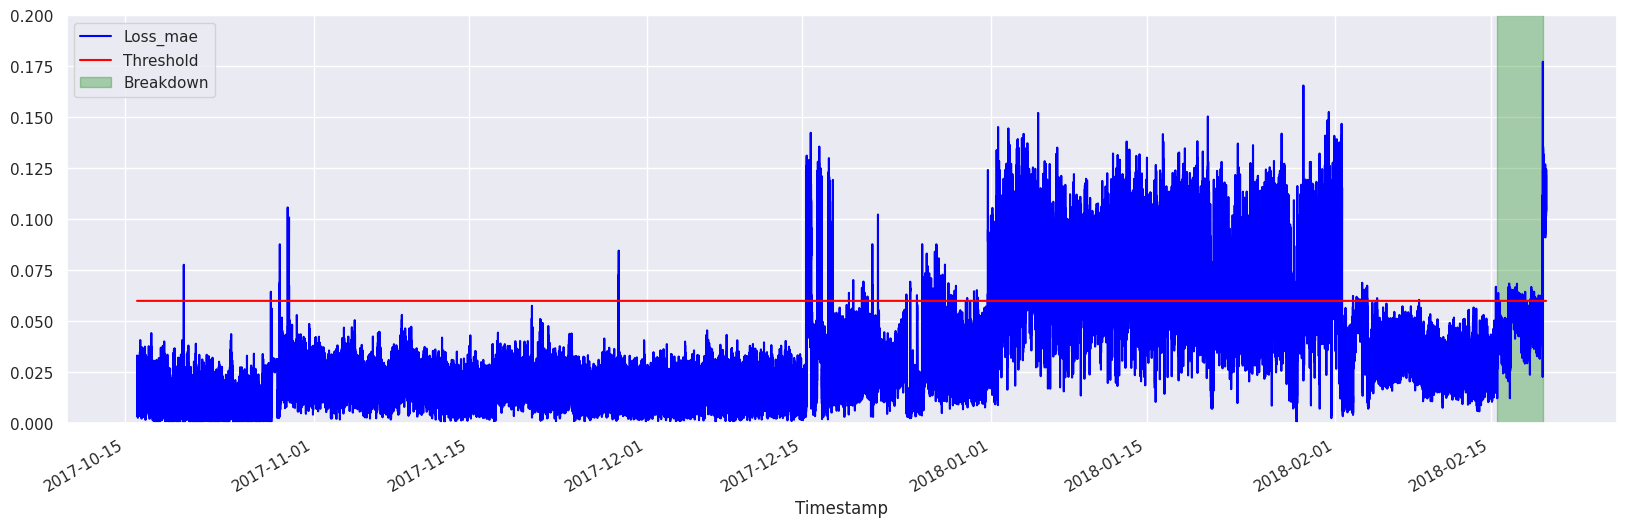

In [ ]:
idx_score = 350000
fig_score = scored[idx_score:].plot(logy=False,  figsize = (20,6), ylim = [0,0.2], color = ['blue','red'])
fig_score.axvspan('2018-02-15 14:22', '2018-02-19 16:55', alpha=0.3, color='green', label='Breakdown')
plt.legend()
plt.show()

In [ ]:
scored.to_csv('Autoencoder_Score.csv',sep=';')

In [ ]:
with pd.ExcelWriter('Anomaly Distance & Autoencoder Score.xlsx') as writer:
    anomaly_alldata.to_excel(writer, sheet_name='Anomaly Distance')
    scored.to_excel(writer, sheet_name='Autoencoder Score')

# Anomaly Detection using Prophet

In [ ]:
!pip install prophet

In [ ]:
import prophet
from prophet import Prophet

In [ ]:
# Creating training dataframe
prophet_healthy_train = pd.DataFrame()
prophet_healthy_train['ds'] = dataset_train.index
prophet_healthy_train['y'] = dataset_train['GND_EX'].values

prophet_healthy_train.tail()

,ds,y
305276,2017-09-14 23:56:00,0.434876
305277,2017-09-14 23:57:00,0.480652
305278,2017-09-14 23:58:00,0.453949
305279,2017-09-14 23:59:00,0.484467
305280,2017-09-15 00:00:00,0.463486


In [ ]:
m = Prophet(interval_width = 1)
# Using the training data from "healthy part"
m.fit(prophet_healthy_train, iter=100)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp61xpc8ts/g1xvtpgk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp61xpc8ts/d6wg5uof.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91466', 'data', 'file=/tmp/tmp61xpc8ts/g1xvtpgk.json', 'init=/tmp/tmp61xpc8ts/d6wg5uof.json', 'output', 'file=/tmp/tmp61xpc8ts/prophet_modeljpentcst/prophet_model-20240109080630.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=100']
08:06:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:06:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
forecast = m.predict(prophet_healthy_train)
forecast['fact'] = prophet_healthy_train['y'].reset_index(drop = True)


Displaying Prophet plot


[Text(0.5, 32.249999999999986, 'Month (MM)-Date(DD) Time'),
 Text(82.0, 0.5, 'Vibration/Acceleration(g)')]

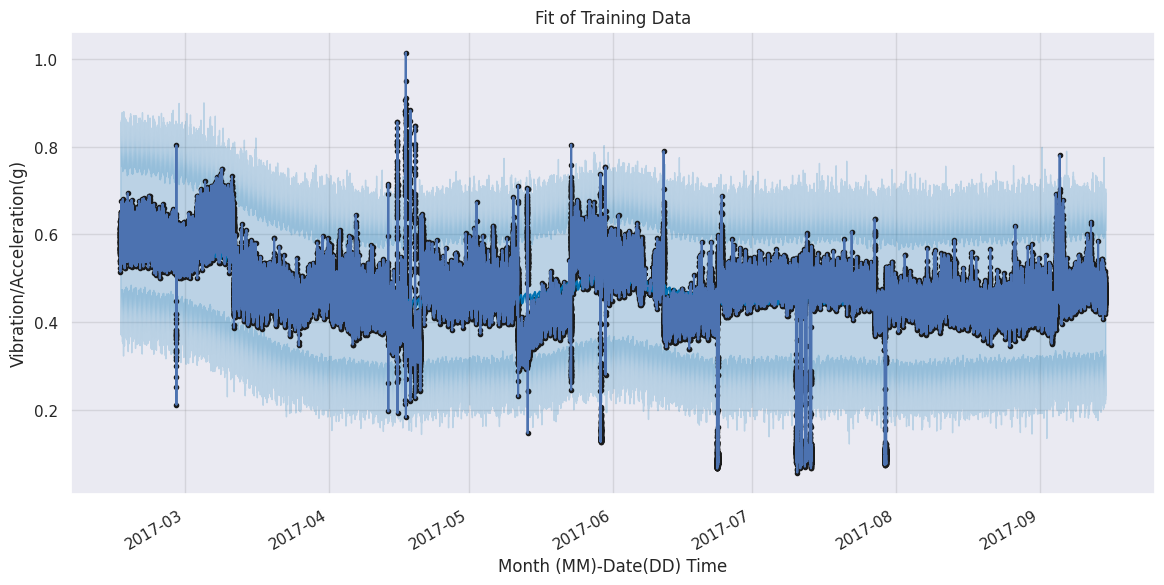

In [ ]:
print('Displaying Prophet plot')
fig1 = m.plot(forecast)
fig1 = dataset_train['GND_EX'].plot(figsize = (12,6), title="Fit of Training Data")
fig1.set(xlabel="Month (MM)-Date(DD) Time", ylabel="Vibration/Acceleration(g)")

In [ ]:
prophet_faulty_test = pd.DataFrame()
prophet_faulty_test['ds'] = dataset_test.index
prophet_faulty_test['y'] = dataset_test['GND_EX'].values

In [ ]:
forecast_test = m.predict(prophet_faulty_test)
forecast_test['fact'] = prophet_faulty_test['y'].reset_index(drop = True)

Displaying Prophet plot


[Text(0.5, 32.249999999999986, 'Month (MM)-Date(DD) Time'),
 Text(83.875, 0.5, 'Vibration/Acceleration(g)')]

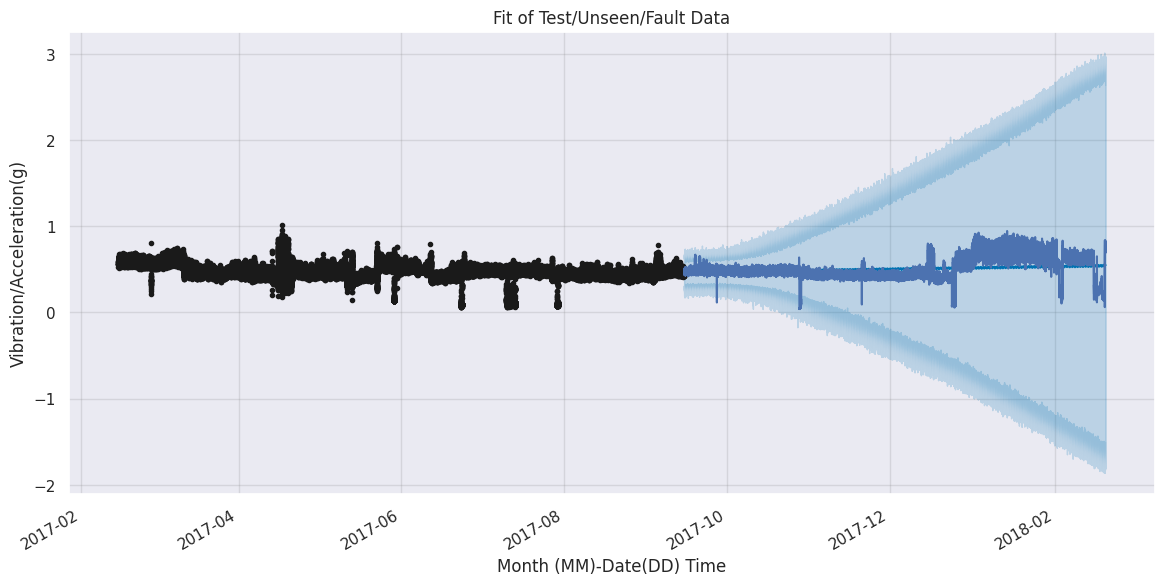

In [ ]:
print('Displaying Prophet plot')
fig2 = m.plot(forecast_test)
fig2 = dataset_test['GND_EX'].plot(figsize = (12,6),title="Fit of Test/Unseen/Fault Data")
fig2.set(xlabel="Month (MM)-Date(DD) Time", ylabel="Vibration/Acceleration(g)")